# ODE models
The following notebook contains the code that was used to produce all plots in the report for the ODE chapter.

Note that all previous cells must be executed for the code to work.

For reference: the full notebook took about 18 minutes to run on my local machine.
The reader is advised *not* to run cell 6 and 9 in order to minimise computational time.

In [1]:
# importing modules
from IPython.display import clear_output
import numpy as np
import scipy.integrate as sc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def dynamics(x_0, e_l, e_r, times, solver, averaging):
    def dx_dt(t,x):
        agents = x.shape[0]
        x_prime = np.zeros(agents)
            
        row_matrix = np.tile(x, (agents,1))
        col_matrix = row_matrix.transpose()
        dist_matrix = row_matrix - col_matrix
        tf_1 = dist_matrix <= e_r
        tf_2 = dist_matrix >= -e_l
        considered = np.logical_and(tf_1, tf_2)
        considered_dist = np.ma.masked_where(~considered, dist_matrix)
        if averaging == "sumn":
            x_prime = np.sum(considered_dist, axis = 1)/agents
        elif averaging == "sum":
            x_prime = np.sum(considered_dist, axis = 1)
        elif averaging == "interfu":
            considered_all = np.logical_and(tf_1, tf_2)
            considered_r = np.logical_and(considered_all, dist_matrix>=0)
            considered_l = np.logical_and(considered_all, dist_matrix<0)
            weights_r = np.ma.masked_where(~considered_r, 1 - abs(dist_matrix)/e_r).filled(0)
            weights_l = np.ma.masked_where(~considered_l, 1 - abs(dist_matrix)/e_l).filled(0)
            weights = weights_r + weights_l
            x_prime = np.average(dist_matrix, axis = 1, weights = weights)
        else:
            x_prime = np.mean(considered_dist, axis = 1)
        return x_prime
    def event(t,y):
        change = abs(dx_dt(t,y))
        change_tf = change < 10**(-5)
        if change_tf.all():
            return 0
        else:
            return 1
    event.terminal = True
    
    result = sc.solve_ivp(dx_dt, times, x_0, solver, events = event, rtol=0.00002)
    return result

def display(x_0, e_l, e_r, times, solver, averaging):
    result = dynamics(x_0, e_l, e_r, times, solver, averaging)
    agents = x_0.shape[0]
    cmap = plt.get_cmap('viridis')
    colors = [cmap(i) for i in np.linspace(0, 1, agents)]
    for a in range(agents):
        plt.plot(result.t, result.y[a, :], color=colors[a], linewidth=0.7)
        
        
def cluster_analysis(x_0, e_l, e_r, times, solver, averaging):
    result = dynamics(x_0, e_l, e_r, times, solver, averaging)
    #print(result.t_events[0][0])
    stable_pattern = result.y[:,-1]
    
    opinions = [stable_pattern[0]]
    count_in_cluster = [1]
    stability_control = min(e_l, e_r)/4
    k = 0
    for i in range(1, stable_pattern.shape[0]):
        if abs(stable_pattern[i-1] - stable_pattern[i]) < stability_control:
            count_in_cluster[k] +=1
        else:
            opinions.append(stable_pattern[i])
            count_in_cluster.append(1)
            k += 1
    if len(result.t_events[0]) == 0:
        t = 0
    else:
        t= result.t_events[0][0]
    return opinions, count_in_cluster, t

## Figure 2.1

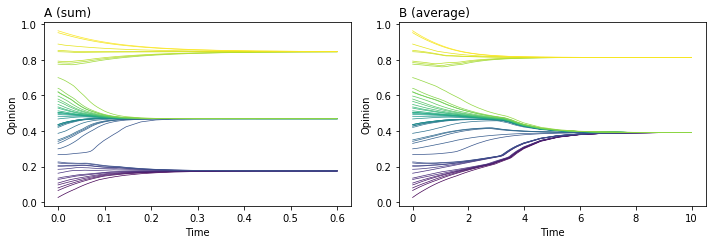

In [3]:
# Averaging sample
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10, 3.5)
np.random.seed(2)
x_0 = np.sort(np.random.uniform(0,1,50))
e_l = 0.2
e_r = 0.2
solver = 'RK45'


plt.sca(ax[0])
times = (0,0.6)
display(x_0, e_l, e_r, times, solver, averaging = "sum")
plt.title("A (sum)", loc="left")
plt.xlabel("Time")
plt.ylabel("Opinion")

plt.sca(ax[1])
times = (0,10)
display(x_0, e_l, e_r, times, solver, averaging = "mean")
plt.title("B (average)", loc="left")
plt.xlabel("Time")
plt.ylabel("Opinion")
plt.tight_layout()
plt.show()

## Figure 2.2

In [4]:
samples = 100
e_l = 0.2
e_r = e_l

results_sum = np.zeros(samples)
results_mean = np.zeros(samples)

for i in range(samples):
    clear_output(wait=True)
    print("progress: ", i, " out of ", samples)
    np.random.seed(i)
    x_0 = np.sort(np.random.uniform(0,1,50))
    results_sum[i] = len(cluster_analysis(x_0, e_l, e_r, times = (0,4), solver = 'RK45', averaging = "sum")[0])
    results_mean[i] = len(cluster_analysis(x_0, e_l, e_r, times = (0,40), solver = 'RK45', averaging = "mean")[0])

progress:  99  out of  100


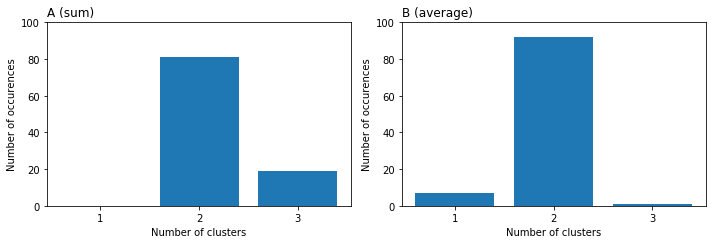

In [5]:
count_1 = 0
count_2 = 0
count_3 = 0
count_4 = 0
count_more = 0
for r in results_sum:
    if r == 1:
        count_1 += 1
    if r == 2:
        count_2 +=1
    elif r == 3:
        count_3 += 1
    elif r == 4:
        count_4 += 1
    else:
        count_more += 1
counts_sum = [count_1, count_2, count_3]

count_1 = 0
count_2 = 0
count_3 = 0
count_4 = 0
count_more = 0
for r in results_mean:
    if r == 1:
        count_1 += 1
    if r == 2:
        count_2 +=1
    elif r == 3:
        count_3 += 1
    elif r == 4:
        count_4 += 1
    else:
        count_more += 1
counts_mean = [count_1, count_2, count_3]
xax = [1,2,3]

fig, ax = plt.subplots(1,2)
fig.set_size_inches(10, 3.5)

plt.sca(ax[0])
plt.bar(xax, counts_sum)
plt.ylim([0,100])
plt.xticks(xax, xax)
plt.xlabel('Number of clusters')
plt.ylabel('Number of occurences')
plt.title('A (sum)', loc = 'left')

plt.sca(ax[1])
plt.bar(xax, counts_mean)
plt.ylim([0,100])
plt.xticks(xax, xax)
plt.xlabel('Number of clusters')
plt.ylabel('Number of occurences')
plt.title('B (average)', loc = 'left')

plt.tight_layout()

## Figure 2.3
Since the first cell takes fairly long, when the dynamics are calculated for all 100 samples, we only calculate the result for 1 sample and store it in the `clusters_ODE_FixAs_1.csv` file. 

Even calculating one sample only takes a long time. The reader is advised to run the second cell only.

The second cell makes use of the `clusters_ODE_FixAs.csv` file which stores the result for when the cell below is run for 100 samples.

progress:  0  out of  1
progress:  49  out of  50


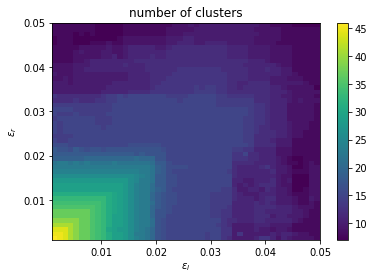

In [6]:
def dynamics(x_0, e_l, e_r, times, solver):
    def dx_dt(t,x):
        agents = x.shape[0]
        x_prime = np.zeros(agents)
            
        row_matrix = np.tile(x, (agents,1))
        col_matrix = row_matrix.transpose()
        dist_matrix = row_matrix - col_matrix
        tf_1 = dist_matrix <= e_r
        tf_2 = dist_matrix >= -e_l
        considered = np.logical_and(tf_1, tf_2)
        considered_dist = np.ma.masked_where(~considered, dist_matrix)
        #x_prime = np.sum(considered_dist, axis = 1)
        x_prime = np.mean(considered_dist, axis = 1)
        return x_prime
    def event(t,y):
        change = abs(dx_dt(t,y))
        change_tf = change < 10**(-5)
        if change_tf.all():
            return 0
        else:
            return 1
    event.terminal = True
    
    result = sc.solve_ivp(dx_dt, times, x_0, solver, events = event, rtol=0.00002)
    return result

def display(x_0, e_l, e_r, times, solver):
    result = dynamics(x_0, e_l, e_r, times, solver)
    agents = x_0.shape[0]
    cmap = plt.get_cmap('viridis')
    colors = [cmap(i) for i in np.linspace(0, 1, agents)]
    for a in range(agents):
        plt.plot(result.t, result.y[a, :], color=colors[a], linewidth=0.3)
        
        
def cluster_analysis(x_0, e_l, e_r, times, solver):
    result = dynamics(x_0, e_l, e_r, times, solver)
    #print(result.t_events[0][0])
    stable_pattern = result.y[:,-1]
    
    opinions = [stable_pattern[0]]
    count_in_cluster = [1]
    stability_control = min(e_l, e_r)/4
    k = 0
    for i in range(1, stable_pattern.shape[0]):
        if abs(stable_pattern[i-1] - stable_pattern[i]) < stability_control:
            count_in_cluster[k] +=1
        else:
            opinions.append(stable_pattern[i])
            count_in_cluster.append(1)
            k += 1
    if len(result.t_events[0]) == 0:
        t = 0
    else:
        t= result.t_events[0][0]
    return opinions, count_in_cluster, t



e_l_range = [0.001,0.05]
e_r_range = [0.001,0.05]
N = 50
sample = 1

count_grids = []
for k in range(sample):
    np.random.seed(k)
    x_0 = np.sort(np.random.uniform(0,1,50))
    grid_count = np.zeros([N, N])
    e_ls = np.linspace(e_l_range[0], e_l_range[1], N)
    e_rs = np.linspace(e_r_range[0], e_r_range[1], N)

    for i in range(N):
        clear_output(wait=True)
        print("progress: ", k, " out of ", sample)
        print("progress: ", i, " out of ", N)
        e_l = e_ls[i]
        for j in range(N):
            e_r = e_rs[j]
            grid_count[i,j] = len(cluster_analysis(x_0, e_l, e_r, (0,15), 'RK45')[0])
    count_grids.append(grid_count)
    
    
    
countgrid_final = np.mean(count_grids, axis =0)

np.savetxt('./savedResults/clusters_ODE_FixAs_' + str(sample) + '.csv', countgrid_final, delimiter=';')

plt.pcolormesh(e_ls, e_rs, countgrid_final, cmap="viridis")
plt.colorbar()
plt.xlabel("$\epsilon_l$")
plt.ylabel("$\epsilon_r$")
plt.title("number of clusters")

plt.show()

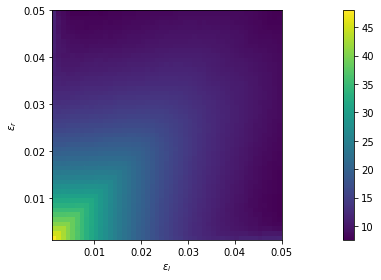

In [7]:
def plot_grid(i_values, j_values, matrix, i_values_label, j_values_label):
    mss, ess = np.meshgrid(j_values, i_values)
    plt.pcolormesh(ess, mss, matrix, cmap="viridis")
    plt.colorbar()
    plt.xlabel(i_values_label)
    plt.ylabel(j_values_label)


e_l_range = [0.001,0.05]
e_r_range = [0.001,0.05]
N = 50
agents = 50
samples = 100 # for calculating sum of a^2
e_ls = np.linspace(e_l_range[0], e_l_range[1], N)
e_rs = np.linspace(e_r_range[0], e_r_range[1], N)
countgrid = np.genfromtxt('./savedResults/clusters_ODE_FixAs.csv', delimiter=';')


#fig.set_size_inches(20, 10)


plot_grid(e_ls, e_rs, countgrid, "$\epsilon_l$", "$\epsilon_r$")
plt.axis('square')
plt.tight_layout()

## Figure 2.4

(-0.05, 1.05)

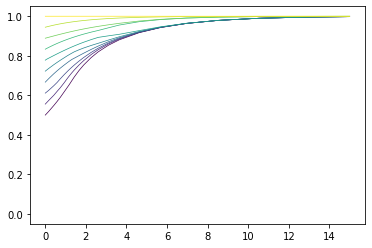

In [8]:
def dynamics(x_0, e, m, times, solver):
    const = (1-m)/2
    def dx_dt(t,x):
        agents = x.shape[0]
        x_prime = np.zeros(agents)
            
        row_matrix = np.tile(x, (agents,1))
        col_matrix = row_matrix.transpose()
        dist_matrix = row_matrix - col_matrix
        b_r = m * col_matrix[:,0] + const*np.ones(agents)
        b_l = np.ones(agents) - b_r
        e_r = np.zeros([agents,1])
        e_r[:,0] = e*b_r
        e_l = np.zeros([agents,1])
        e_l[:,0] = e*b_l
        tf_1 = dist_matrix <= e_r
        tf_2 = dist_matrix >= -e_l
        considered = np.logical_and(tf_1, tf_2)
        considered_dist = np.ma.masked_where(~considered, dist_matrix)
        x_prime = np.mean(considered_dist, axis = 1)
        return x_prime
    def event(t,y):
        change = abs(dx_dt(t,y))
        change_tf = change < 10**(-5)
        if change_tf.all():
            return 0
        else:
            return 1
    event.terminal = True
    
    result = sc.solve_ivp(dx_dt, times, x_0, solver, events = event, rtol=0.00002)
    return result

def display(x_0, e, m, times, solver):
    result = dynamics(x_0, e, m, times, solver)
    agents = x_0.shape[0]
    cmap = plt.get_cmap('viridis')
    colors = [cmap(i) for i in np.linspace(0, 1, agents)]
    for a in range(agents):
        plt.plot(result.t, result.y[a, :], color=colors[a], linewidth=0.7)
    
    
    
x_0 = np.sort(np.linspace(0.5,1,10))
e = 0.5
m = 1
times = (0,15)
solver='RK45'
display(x_0, e, m, times, solver)
plt.ylim([-0.05,1.05])

## Figure 2.5
Since the first cell takes fairly long, when the dynamics are calculated for all 100 samples, we only calculate the result for 1 sample and store it in the `clusters_ODE_OpdepAs_1.csv` file. 

Even calculating one sample only takes a long time. The reader is advised to run the second cell only.

The second cell makes use of the `clusters_ODE_OpdepAs.csv` file which stores the result for when the cell below is run for 100 samples.

progress:  0  out of  1
progress:  49  out of  50


Text(0.5, 1.0, 'number of clusters')

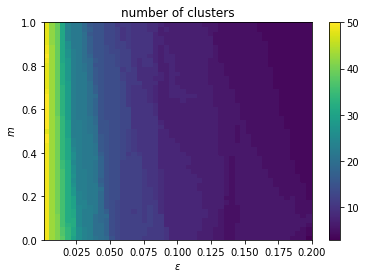

In [9]:
def cluster_analysis(x_0, e, m, times, solver):
    result = dynamics(x_0, e, m, times, solver)
    #print(result.t_events[0][0])
    stable_pattern = result.y[:,-1]
    
    opinions = [stable_pattern[0]]
    count_in_cluster = [1]
    stability_control = e/4
    k = 0
    for i in range(1, stable_pattern.shape[0]):
        if abs(stable_pattern[i-1] - stable_pattern[i]) < stability_control:
            count_in_cluster[k] +=1
        else:
            opinions.append(stable_pattern[i])
            count_in_cluster.append(1)
            k += 1
    if len(result.t_events[0]) == 0:
        t = 0
    else:
        t= result.t_events[0][0]
    return opinions, count_in_cluster, t

e_range = [0.001,0.2]
m_range = [0.0,1]
N = 50
sample = 1

es = np.linspace(e_range[0], e_range[1], N)
ms = np.linspace(m_range[0], m_range[1], N)

count_grids = []
for k in range(sample):
    x_0 = np.sort(np.random.uniform(0,1,50))
    grid_count = np.zeros([N, N])

    for i in range(N):
        clear_output(wait=True)
        print("progress: ", k, " out of ", sample)
        print("progress: ", i, " out of ", N)
        e = es[i]
        for j in range(N):
            m = ms[j]
            grid_count[i,j] = len(cluster_analysis(x_0, e, m, (0,20), 'RK45')[0])
    count_grids.append(grid_count)
    
    
    
countgrid_final_as = np.mean(count_grids, axis =0)
np.savetxt('./savedResults/clusters_ODE_OpdepAs_' + str(sample) + '.csv', countgrid_final_as, delimiter=';')
mss, ess = np.meshgrid(ms, es)

plt.pcolormesh(ess, mss, countgrid_final_as, cmap="viridis")
plt.colorbar()
plt.xlabel("$\epsilon$")
plt.ylabel("$m$")
plt.title("number of clusters")


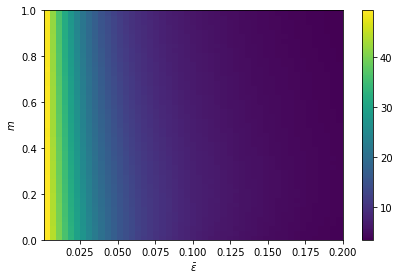

In [10]:
e_range = [0.001,0.2]
m_range = [0.0,1]
N = 50
sample = 150
es = np.linspace(e_range[0], e_range[1], N)
ms = np.linspace(m_range[0], m_range[1], N)
countgrid = np.genfromtxt('./savedResults/clusters_ODE_OpdepAs.csv', delimiter=';')

plot_grid(es, ms, countgrid, "$\\bar{\epsilon}$", "$m$")
plt.tight_layout()
plt.show()